# Implementing Decision Trees from Scratch #
    - Matt Robinson
    
The code here is loosely based on the code found in Jason Brownlee's [nice tutorial](https://machinelearningmastery.com/implement-decision-tree-algorithm-scratch-python/).

In [2]:
# Common imports
import numpy as np
import pandas as pd

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# get the Iris dataset from seaborn
df = sns.load_dataset("iris")
df.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In [4]:
from sklearn.model_selection import train_test_split

X, y = df.iloc[:, 0:4].values, df.iloc[:, 4].values

X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.3, 
                     stratify=y,
                     random_state=0)

In [17]:
def gini(X,y):
    N = X.shape[0]
    
    gini_score = 1
    for class_i in np.unique(y):
        Ni = X[y==class_i].shape[0]
        gini_score -= (Ni/N)**2
        
    return gini_score   
    

In [16]:
gini(X[0:100],y[0:100])

0.5

In [55]:
def test_split(X,y,sample_idx=0,feature_idx=0):
    value_to_split_on = X[sample_idx,feature_idx]
    
    left_idx = X[:,0] <= value_to_split_on
    left_X = X[left_idx]
    left_y = y[left_idx]
    
    right_idx = X[:,0] > value_to_split_on
    right_X = X[right_idx]
    right_y = y[right_idx]
    
    return left_X, left_y, right_X, right_y
    

In [92]:
# Select the best split point for a dataset
def get_split(X, y, min_samples_leaf=0):
    
    N = X.shape[0]
    num_features = X.shape[1]
    
    best_gini_cost = gini(X,y)
    found_split = False
    
    for j in range(num_features):
        for i in range(N):
            # this is really simplistic
            # just iterate over every feature value
            # for every sample, and see what produces
            # the best split of left and right
            # in terms of Gini impurity
            lX,ly,rX,ry = test_split(X, y, sample_idx=i, feature_idx=j)
            left_gini = gini(lX,ly)
            right_gini = gini(rX,ry)
            
            gini_cost = (len(lX)/N)*left_gini + (len(rX)/N)*right_gini
            if (gini_cost < best_gini_cost) and \
                (len(lX) >= min_samples_leaf) and \
                (len(rX) >= min_samples_leaf):
                    
                found_split = True
                best_gini_cost = gini_cost
                best_gini_feature_idx = j
                best_gini_feature_value = X[i,j]
                best_lX, best_ly = lX,ly
                best_rX, best_ry = rX,ry
    
    if found_split:
        return {"feature_idx": best_gini_feature_idx, 
                "feature_value": best_gini_feature_value, 
                "left": [best_lX, best_ly],
                "right": [best_rX, best_ry]}
    else:
        return {"leaf": [X,y]}
            


In [97]:
# Create child splits for a node or make leaf
def split(node, depth, max_depth=2, min_samples_split=0, min_samples_leaf=0):
    
    if "leaf" in node:
        return
    
    lX,ly = node['left'][:]
    rX,ry = node['right'][:]
    
    # get rid of old info
    del(node['left'])
    del(node['right'])
    
    if depth >= max_depth-1:
        node["left"] = {"leaf": [lX,ly]}
        node["right"] = {"leaf": [rX,ry]}
        return
    
    if (len(lX) < min_samples_split) and (len(rX) < min_samples_split):
        node["left"] = {"leaf": [lX,ly]}
        node["right"] = {"leaf": [rX,ry]}
        return
    
    elif (len(lX) < min_samples_split) and (len(rX) >= min_samples_split):
        node["left"] = {"leaf": [lX,ly]}
        node["right"] = get_split(rX,rY,min_samples_leaf)
        split(node["right"], depth+1, max_depth, min_samples_split, min_samples_leaf)
    
    elif (len(lX) >= min_samples_split) and (len(rX) < min_samples_split):
        node["right"] = {"leaf": [rX,ry]}
        node["left"] = get_split(lX,lY,min_samples_leaf)
        split(node["left"], depth+1, max_depth, min_samples_split, min_samples_leaf)
    
    else:
        node["left"] = get_split(lX,ly,min_samples_leaf)
        split(node["left"], depth+1, max_depth, min_samples_split, min_samples_leaf)
        
        node["right"] = get_split(rX,ry,min_samples_leaf)
        split(node["right"], depth+1, max_depth, min_samples_split, min_samples_leaf)


In [101]:
def make_tree():
    root = get_split(X,y)
    split(root, 0, max_depth=2)
    return root

In [103]:
make_tree()

{'feature_idx': 0,
 'feature_value': 5.4,
 'left': {'feature_idx': 0,
  'feature_value': 4.8,
  'left': {'leaf': [array([[4.7, 3.2, 1.3, 0.2],
           [4.6, 3.1, 1.5, 0.2],
           [4.6, 3.4, 1.4, 0.3],
           [4.4, 2.9, 1.4, 0.2],
           [4.8, 3.4, 1.6, 0.2],
           [4.8, 3. , 1.4, 0.1],
           [4.3, 3. , 1.1, 0.1],
           [4.6, 3.6, 1. , 0.2],
           [4.8, 3.4, 1.9, 0.2],
           [4.7, 3.2, 1.6, 0.2],
           [4.8, 3.1, 1.6, 0.2],
           [4.4, 3. , 1.3, 0.2],
           [4.5, 2.3, 1.3, 0.3],
           [4.4, 3.2, 1.3, 0.2],
           [4.8, 3. , 1.4, 0.3],
           [4.6, 3.2, 1.4, 0.2]]),
    array(['setosa', 'setosa', 'setosa', 'setosa', 'setosa', 'setosa',
           'setosa', 'setosa', 'setosa', 'setosa', 'setosa', 'setosa',
           'setosa', 'setosa', 'setosa', 'setosa'], dtype=object)]},
  'right': {'leaf': [array([[5.1, 3.5, 1.4, 0.2],
           [4.9, 3. , 1.4, 0.2],
           [5. , 3.6, 1.4, 0.2],
           [5.4, 3.9, 1.7, 0.4],


In [ ]:
# Make a prediction with a decision tree
def predict(node, X):
    
    # if leaf, then predict
    # based on most popular class in leaf
    if "leaf" in node:
        leaf_X, leaf_y = node["leaf"][:]
        
        
    if row[node['feature_idx']] < node['value']:
		if isinstance(node['left'], dict):
			return predict(node['left'], row)
		else:
			return node['left']
	else:
		if isinstance(node['right'], dict):
			return predict(node['right'], row)
		else:
			return node['right']

(array([ 1.,  0.,  5.,  5.,  8.,  9., 10.,  5.,  1.,  6.]),
 array([4.9, 5.2, 5.5, 5.8, 6.1, 6.4, 6.7, 7. , 7.3, 7.6, 7.9]),
 <a list of 10 Patch objects>)

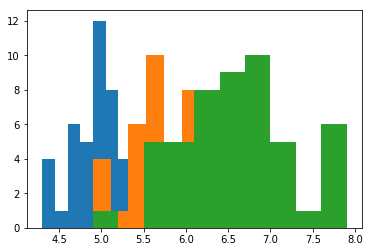

In [75]:
plt.hist(X[:,0][y=='setosa'])
plt.hist(X[:,0][y=='versicolor'])
plt.hist(X[:,0][y=='virginica'])

In [107]:
unique, counts = np.unique(y, return_counts=True)

In [108]:
unique

array(['setosa', 'versicolor', 'virginica'], dtype=object)

In [109]:
counts

array([50, 50, 50])

In [ ]:
# then sort them